In [1]:
import importlib
import random

from matplotlib import pyplot as plt
plt.rcParams["savefig.bbox"] = "tight"
import numpy as np
import scipy.sparse

from rdkit import Chem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

In [2]:
from vendi_score import vendi, data_utils, molecule_utils

### Load data

Clone the [Molecular Sets (MOSES)](https://github.com/molecularsets/moses) repository.

In [3]:
# ! git clone https://github.com/molecularsets/moses.git

In [4]:
mol_groups = {}
for model in ("aae", "char_rnn", "combinatorial", "hmm", "jtn", "latent_gan", "ngram", "vae"):
    mol_groups[model] = data_utils.Group(model, molecule_utils.load_molecules(
        f"../../moses/data/samples/{model}/{model}_3.csv",
        max_samples=1500
    ))

In [5]:
mol_groups["real"] = data_utils.Group("real", molecule_utils.load_molecules(
    f"../../moses/data/test.csv",
    max_samples=1500
))

### Comparing molecule models

In [6]:
groups = mol_groups.values()
for group in groups:
    group.Ks["morgan"] = K = molecule_utils.get_tanimoto_K([e.x for e in group.examples], fp="morgan")
    group.metrics["VS"] = vendi.score_K(K)
    group.metrics["IntDiv"] = vendi.intdiv_K(K)
    print(group.name, round(group.metrics["VS"], 2), round(group.metrics["IntDiv"], 4))

aae 501.05 0.8592
char_rnn 482.44 0.8563
combinatorial 536.89 0.8729
hmm 250.89 0.8707
jtn 489.54 0.8556
latent_gan 486.4 0.8569
ngram 479.8 0.8736
vae 475.28 0.8562
real 403.93 0.8551


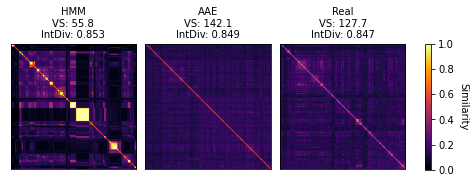

In [7]:
models = ["hmm", "aae", "real"]
fig, axes = plt.subplots(1, 3, figsize=(6.5, 3), constrained_layout=True)
models = [("hmm", "HMM"), ("aae", "AAE"), ("real", "Real")]
for (model_key, model_name), ax in zip(models, axes):
    group = mol_groups[model_key]
    K = group.Ks["morgan"]
    order = np.argsort(np.array([e.features["s"] for e in group.examples]))[:250]
    K = K[order][:, order]
    im = ax.imshow(K, vmin=0, vmax=1, cmap="inferno")
    #vnd, intdiv = group.metrics["vNd"], group.metrics["IntDiv"]
    vnd = vendi.score_K(K)
    intdiv = vendi.intdiv_K(K)
    ax.set_title(model_name + f"\nVS: {vnd:.01f}" + f"\nIntDiv: {intdiv:.03f}", size=10)
    ax.set_xticks([])
    ax.set_yticks([])
cbar = fig.colorbar(im, ax=axes, location="right", shrink=0.6)
cbar.ax.set_ylabel("Similarity", rotation=-90, va="bottom", size=10)
plt.savefig("molecule_kernels.pdf", dpi=300)
plt.show()